# Analysing GTSRB

In [16]:
import json
from pathlib import Path
import matplotlib.pyplot as plt


def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def plot_eval_acc_max_per_group(
    dataset_dir: str | Path,
    *,
    group_by: tuple[str, ...] = ("dropout", "augment"),
    show_print: bool = False,
    show_plot: bool = True,
    save_path: str | Path | None = None,
):
    """
    For a dataset folder like runs/LENET5/CIFAR10 or runs/LENET5/GTSRB:
      - reads all run subfolders with config.json + history.json
      - groups runs by keys in `group_by` (default: dropout + augment)
      - for each group picks the run with the maximum number of epochs
        (measured by len(history['eval_acc']) or config['epochs'])
      - plots eval_acc vs epoch per group (linestyle by augment)

    This matches your CIFAR10 situation where aug=1 was trained longer than aug=0.
    """
    dataset_dir = Path(dataset_dir)
    if not dataset_dir.exists() or not dataset_dir.is_dir():
        raise ValueError(f"dataset_dir does not exist or is not a dir: {dataset_dir}")

    # collect run dirs (your structure: dataset_dir/<run_name>/config.json etc.)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]
    if not run_dirs:
        raise RuntimeError(f"No run folders with config.json+history.json found in: {dataset_dir}")

    runs = []
    for rd in run_dirs:
        try:
            cfg = _load_json(rd / "config.json")
            hist = _load_json(rd / "history.json")
        except Exception as e:
            print(f"[WARN] Skip {rd}: cannot read json ({e})")
            continue

        eval_acc = hist.get("eval_acc")
        if not isinstance(eval_acc, list) or len(eval_acc) == 0:
            print(f"[WARN] Skip {rd}: missing/empty history['eval_acc']")
            continue

        # parse fields (your config keys)
        try:
            dropout = float(cfg.get("dropout"))
        except Exception:
            dropout = cfg.get("dropout")

        try:
            augment = int(cfg.get("augment"))
        except Exception:
            augment = cfg.get("augment")

        # config epochs might exist but we primarily trust eval_acc length
        cfg_epochs = cfg.get("epochs")
        try:
            cfg_epochs = int(cfg_epochs)
        except Exception:
            cfg_epochs = None

        runs.append(
            {
                "run_dir": rd,
                "cfg": cfg,
                "eval_acc": eval_acc,
                "dropout": dropout,
                "augment": augment,
                "cfg_epochs": cfg_epochs,
            }
        )

    if not runs:
        raise RuntimeError(f"Found run dirs, but none were usable in: {dataset_dir}")

    # group and select max epochs run per group
    best = {}
    for r in runs:
        key_parts = []
        for k in group_by:
            if k == "dropout":
                key_parts.append(r["dropout"])
            elif k == "augment":
                key_parts.append(r["augment"])
            else:
                key_parts.append(r["cfg"].get(k))
        key = tuple(key_parts)

        # "epochs achieved" = length of eval_acc (most reliable)
        achieved_epochs = len(r["eval_acc"])

        if key not in best or achieved_epochs > len(best[key]["eval_acc"]):
            best[key] = r

    if show_print:
        print(f"\nDataset: {dataset_dir.name}")
        print(f"Runs found (usable): {len(runs)}")
        print(f"Groups ({group_by}) plotted: {len(best)}")
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            print("-" * 90)
            print(f"group={key} | run={r['run_dir'].name} | epochs_used={len(r['eval_acc'])}")

    # plot
    if show_plot or save_path is not None:
        # linestyle by augmentation (extend as needed)
        ls_map = {0: "-", 1: "--"}

        plt.figure(figsize=(10, 6))
        for key, r in sorted(best.items(), key=lambda x: tuple(str(v) for v in x[0])):
            y = r["eval_acc"]
            x = list(range(1, len(y) + 1))

            aug = r["augment"]
            ls = ls_map.get(aug, "-.")
            label = f"dropout={r['dropout']}, aug={aug}, epochs={len(y)}"

            plt.plot(x, y, linestyle=ls, label=label)

        plt.xlabel("epoch")
        plt.ylabel("test accuracy")
        plt.title(f"{dataset_dir.name}: test accuracy vs epoch (max epochs per group)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()

        if save_path is not None:
            save_path = Path(save_path)
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=200)

        if show_plot:
            plt.show()
        else:
            plt.close()

    return best

In [63]:
import json
from pathlib import Path
import math
import matplotlib.pyplot as plt


def _load_json(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def _mean(xs):
    return sum(xs) / len(xs) if xs else float("nan")


def _std(xs):
    if not xs:
        return float("nan")
    m = _mean(xs)
    return math.sqrt(sum((x - m) ** 2 for x in xs) / len(xs))


def load_best_runs_per_group(dataset_dir: str | Path):
    """
    Returns dict: (dropout, augment) -> run_dict
    Picks the run with the longest eval_acc for each group.
    """
    dataset_dir = Path(dataset_dir)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]

    runs = []
    for rd in run_dirs:
        cfg = _load_json(rd / "config.json")
        hist = _load_json(rd / "history.json")

        eval_acc = hist.get("eval_acc", [])
        train_t = hist.get("train_time_s", [])
        eval_t = hist.get("eval_time_s", [])

        if not eval_acc or not train_t or not eval_t:
            continue

        dropout = float(cfg.get("dropout"))
        augment = int(cfg.get("augment"))

        epochs_cfg = int(cfg.get("epochs"))


        runs.append({
            "run_dir": rd,
            "dropout": dropout,
            "augment": augment,
            "eval_acc": eval_acc,
            "train_time_s": train_t,
            "eval_time_s": eval_t,
            "epochs_cfg": epochs_cfg,
        })

    best = {}
    for r in runs:
        key = (r["dropout"], r["augment"])
        if key not in best or len(r["eval_acc"]) > len(best[key]["eval_acc"]):
            best[key] = r




    if not best:
        raise RuntimeError(f"No usable runs found in {dataset_dir}")
    
    # if is_cifar10 and not best:
    #     raise RuntimeError("CIFAR10: no runs found with epochs_cfg == 15. Train ep=15 for aug=1 too.")


    return best


def runtime_summary(best_runs: dict, threshold: float = 0.60):
    """
    Build summary rows per (dropout, augment).
    Adds:
      - best_test_acc_epoch (epoch index where max test acc occurs; 1-based)
      - time_to_best_test_acc_train_s (cumulative train time up to that epoch)
    """
    rows = []
    for (dropout, aug), r in sorted(best_runs.items(), key=lambda x: (x[0][1], x[0][0])):
        train_t = r["train_time_s"]
        eval_t = r["eval_time_s"]
        acc = r["eval_acc"]  # treated as TEST accuracy

        total_train = sum(train_t)
        total_eval = sum(eval_t)
        total = total_train + total_eval

        mean_train = _mean(train_t)
        std_train = _std(train_t)
        mean_eval = _mean(eval_t)
        std_eval = _std(eval_t)

        # best (max) test accuracy and the epoch where it happens
        best_idx = max(range(len(acc)), key=lambda i: acc[i])
        max_acc = acc[best_idx]
        best_epoch = best_idx + 1  # 1-based for readability

        # cumulative train time until best epoch (inclusive)
        time_to_best = sum(train_t[:best_epoch])

        # time to reach threshold (in train time only)
        t_to_thr = None
        cum_train = 0.0
        for a, t in zip(acc, train_t):
            cum_train += t
            if a >= threshold:
                t_to_thr = cum_train
                break

        rows.append({
            "dropout": dropout,
            "augment": aug,
            "epochs": len(acc),

            # "eval" -> "test" in naming
            "max_test_acc": max_acc,
            "best_test_acc_epoch": best_epoch,
            "time_to_best_test_acc_train_s": time_to_best,

            "total_train_s": total_train,
            "total_eval_s": total_eval,
            "total_s": total,
            "train_s_per_epoch_mean": mean_train,
            "train_s_per_epoch_std": std_train,
            "eval_s_per_epoch_mean": mean_eval,
            "eval_s_per_epoch_std": std_eval,
            f"time_to_{threshold:.2f}_train_s": t_to_thr,
        })
    return rows


def print_runtime_table(rows):
    cols = [
        "dropout", "augment", "epochs",
        "max_test_acc", "best_test_acc_epoch",
        "total_train_s", "total_eval_s", "total_s",
        "train_s_per_epoch_mean", "eval_s_per_epoch_mean",
    ]
    header = " | ".join(f"{c:>24}" for c in cols)
    print(header)
    print("-" * len(header))
    for row in rows:
        parts = []
        for c in cols:
            v = row[c]
            if isinstance(v, float):
                parts.append(f"{v:>24.4f}")
            else:
                parts.append(f"{str(v):>24}")
        print(" | ".join(parts))


def plot_total_time(rows, title="Total training time per config", dataset_name=None, normalize_epochs=None):
    plt.figure(figsize=(10, 5))
    labels = [f"do={r['dropout']}, aug={r['augment']}" for r in rows]
    # values = [r["total_train_s"] for r in rows]
    values = []
    is_cifar10 = (dataset_name is not None and dataset_name.lower() == "cifar10")
    target = normalize_epochs if normalize_epochs is not None else 15

    for r in rows:
        if is_cifar10:
            # normalize to "target epochs" using mean seconds per epoch
            values.append(r["train_s_per_epoch_mean"] * target)
        else:
            values.append(r["total_train_s"])

    plt.bar(labels, values)
    plt.xticks(rotation=30, ha="right")
    # plt.ylabel("total train time (s)")
    if dataset_name is not None and dataset_name.lower() == "cifar10":
        plt.ylabel(f"train time normalized to {target} epochs (s)")
    else:
        plt.ylabel("total train time (s)")

    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_efficiency(rows, title="Max test accuracy vs total train time", dataset_name=None):
    plt.figure(figsize=(7, 5))
    for r in rows:
        plt.scatter(r["total_train_s"], r["max_test_acc"])
        # include the epoch where max is reached
        plt.text(
            r["total_train_s"],
            r["max_test_acc"],
            f"do={r['dropout']}, aug={r['augment']}, ep={r['best_test_acc_epoch']}",
            fontsize=8
        )
    plt.xlabel("total train time (s)")
    plt.ylabel("max test accuracy")
    plt.title(title)
    plt.grid(True)
    # Make CIFAR10 easier to read (adjust limits as you prefer)
    if dataset_name is not None and dataset_name.lower() == "cifar10":
        plt.ylim(0.58, 0.67)   # Beispiel: größerer Bereich

    plt.tight_layout()
    plt.show()



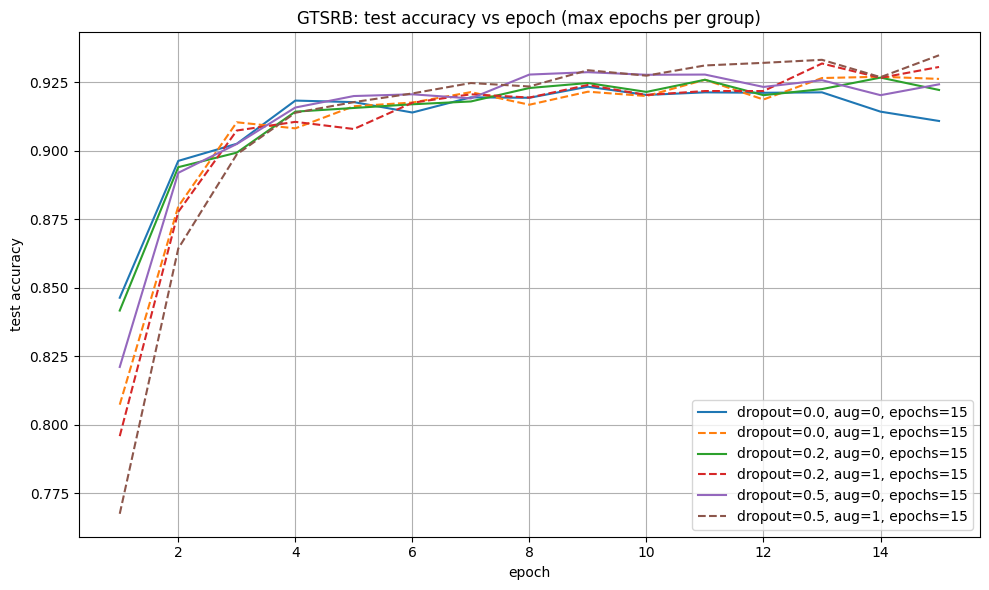

In [27]:
_ = plot_eval_acc_max_per_group("runs/LENET5/GTSRB", save_path="plots_for_analysis/gtsrb_test_acc.png")

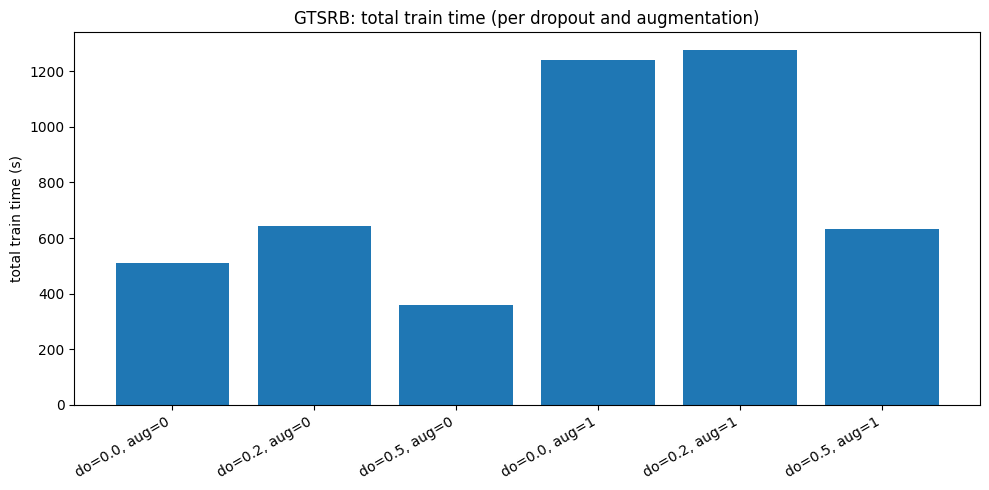

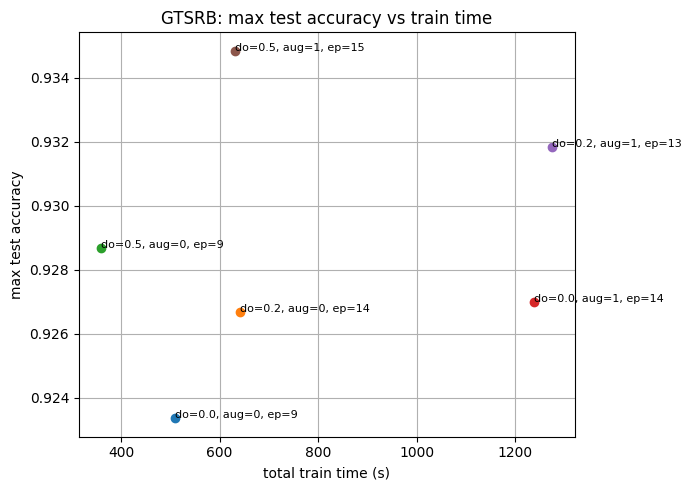

In [48]:
dataset_dir = Path("runs/LENET5/GTSRB")  # change to CIFAR10/GTSRB as needed

best = load_best_runs_per_group(dataset_dir)
rows = runtime_summary(best, threshold=0.60)

# print_runtime_table(rows)
plot_total_time(rows, title=f"{dataset_dir.name}: total train time (per dropout and augmentation)")
plot_efficiency(rows, title=f"{dataset_dir.name}: max test accuracy vs train time")

# Analysing CIFAR-10

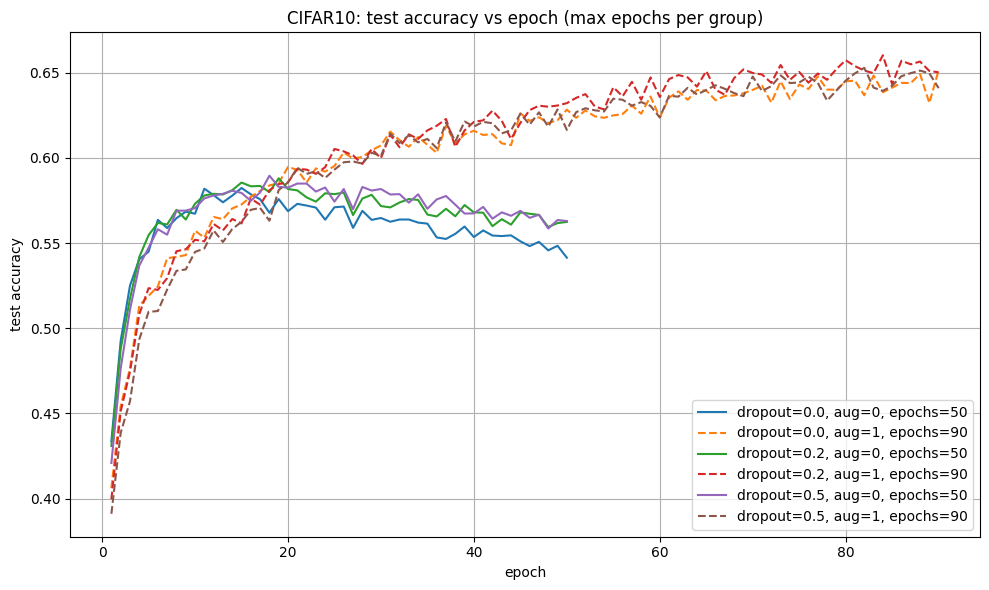

In [29]:
_ = plot_eval_acc_max_per_group("runs/test/LENET5/CIFAR10", save_path="plots_for_analysis/cifar10_test_acc.png")

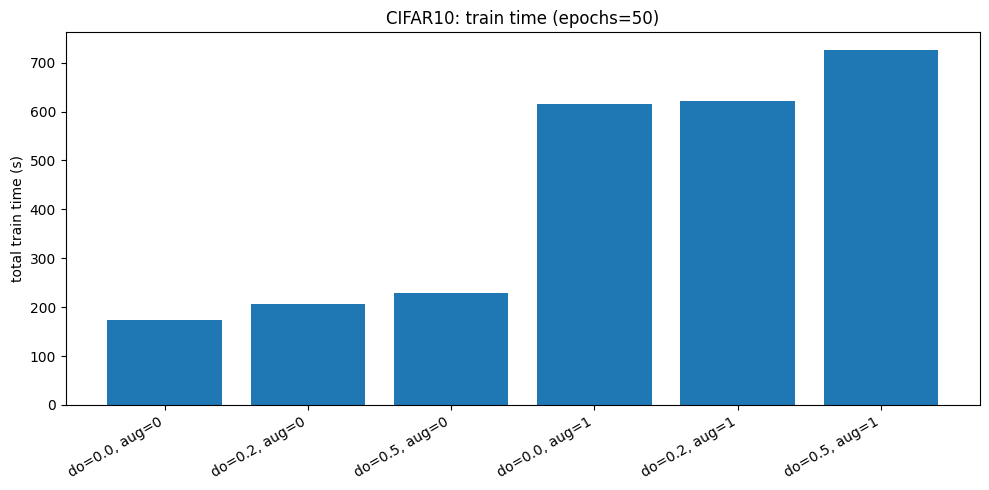

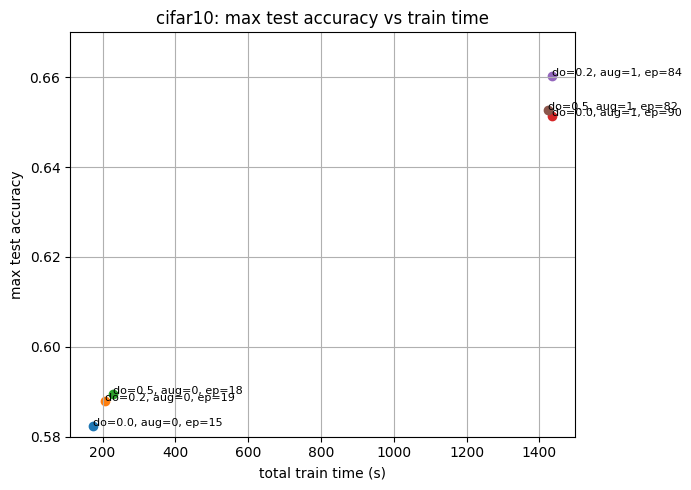

In [70]:
def load_best_runs_per_group_fixed_epochs(dataset_dir: str | Path, target_epochs: int):
    """
    Like load_best_runs_per_group(...), but ONLY considers runs where config['epochs'] == target_epochs.
    If multiple runs exist per (dropout, augment) at that epoch setting, keeps the one with the longest
    history (safety) and/or latest run_dir name ordering.
    """
    dataset_dir = Path(dataset_dir)
    run_dirs = [
        p for p in dataset_dir.iterdir()
        if p.is_dir() and (p / "config.json").exists() and (p / "history.json").exists()
    ]

    runs = []
    for rd in run_dirs:
        cfg = _load_json(rd / "config.json")
        hist = _load_json(rd / "history.json")

        # treat eval_* as TEST, but keep field names unchanged
        eval_acc = hist.get("eval_acc", [])
        train_t = hist.get("train_time_s", [])
        eval_t = hist.get("eval_time_s", [])

        if not eval_acc or not train_t or not eval_t:
            continue

        # filter by epochs in config
        try:
            epochs_cfg = int(cfg.get("epochs"))
        except Exception:
            continue
        if epochs_cfg != int(target_epochs):
            continue

        dropout = float(cfg.get("dropout"))
        augment = int(cfg.get("augment"))

        runs.append({
            "run_dir": rd,
            "dropout": dropout,
            "augment": augment,
            "eval_acc": eval_acc,
            "train_time_s": train_t,
            "eval_time_s": eval_t,
        })

    best = {}
    for r in runs:
        key = (r["dropout"], r["augment"])
        if key not in best:
            best[key] = r
            continue

        # prefer longer history (safety); if tie, prefer "later" run_dir name (often timestamped)
        if len(r["eval_acc"]) > len(best[key]["eval_acc"]):
            best[key] = r
        elif len(r["eval_acc"]) == len(best[key]["eval_acc"]) and r["run_dir"].name > best[key]["run_dir"].name:
            best[key] = r

    if not best:
        raise RuntimeError(f"No usable runs found in {dataset_dir} with epochs=={target_epochs}")

    return best


dataset_dir = Path("runs/test/LENET5/cifar10")  # change to CIFAR10/GTSRB as needed

best = load_best_runs_per_group(dataset_dir)
rows = runtime_summary(best, threshold=0.60)

best_50 = load_best_runs_per_group_fixed_epochs("runs/test/LENET5/CIFAR10", target_epochs=50)
rows_50 = runtime_summary(best_50, threshold=0.60)
plot_total_time(rows_50, title="CIFAR10: train time (epochs=50)")

# print_runtime_table(rows)
# plot_total_time(rows, title=f"{dataset_dir.name}: total train time (per dropout and augmentation)",  dataset_name=dataset_dir.name, normalize_epochs=15)
plot_efficiency(rows, title=f"{dataset_dir.name}: max test accuracy vs train time", dataset_name=dataset_dir.name)

dropout=0.0, aug=0 | MIN epochs=5 | last test acc=0.5450
dropout=0.0, aug=0 | MAX epochs=50 | last test acc=0.5414


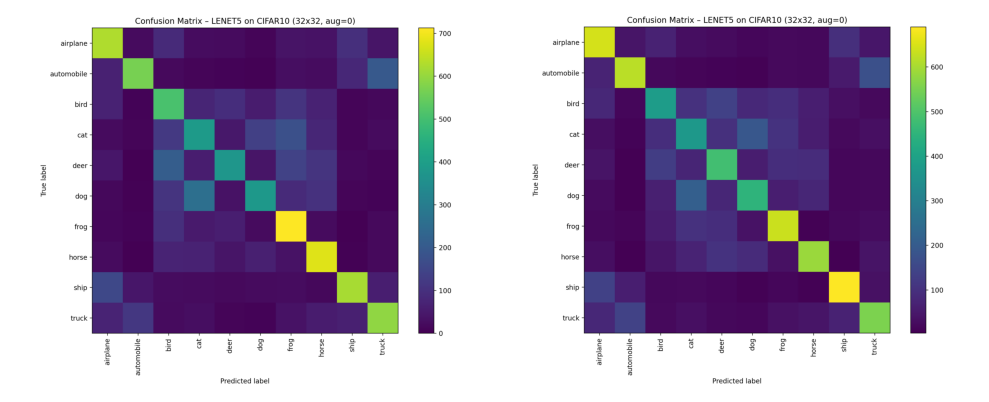

dropout=0.0, aug=1 | MIN epochs=5 | last test acc=0.5190
dropout=0.0, aug=1 | MAX epochs=90 | last test acc=0.6514


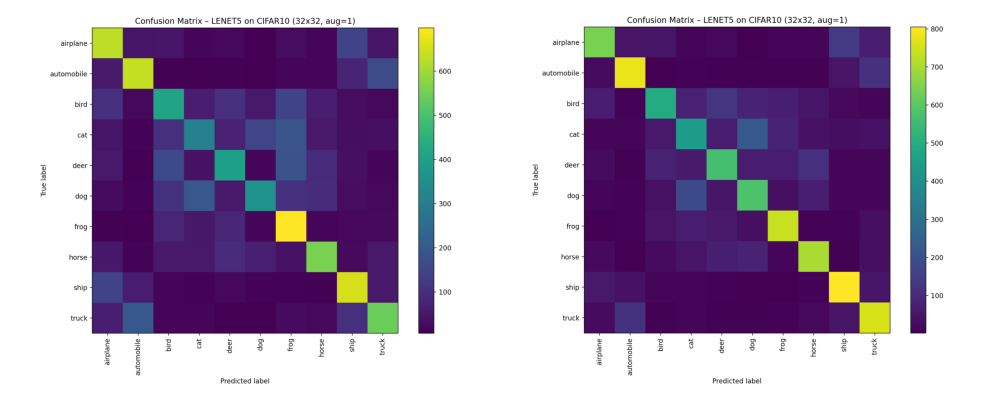

In [77]:
from pathlib import Path
import json
from PIL import Image
import matplotlib.pyplot as plt


def show_confusion_pngs_for_setting(
    dataset_dir: str | Path,
    *,
    dropout: float = 0.0,
    augment: int = 0,
):
    """
    Prints the paths to the confusion-matrix PNGs for:
      - augment=augment, dropout=dropout, MIN epochs_cfg
      - augment=augment, dropout=dropout, MAX epochs_cfg

    Assumptions:
      - structure: <dataset_dir>/<run_name>/config.json
      - each run folder contains ONE confusion-matrix png (we search by common name patterns)
    """
    dataset_dir = Path(dataset_dir)

    def load_cfg(run_dir: Path):
        return json.loads((run_dir / "config.json").read_text(encoding="utf-8"))

    def find_cm_png(run_dir: Path):
        p = run_dir / "confusion_matrix.png"
        return [p] if p.exists() else []


    # collect candidate runs
    candidates = []
    for run_dir in dataset_dir.iterdir():
        if not run_dir.is_dir():
            continue
        cfg_path = run_dir / "config.json"
        if not cfg_path.exists():
            continue

        cfg = load_cfg(run_dir)
        hist = json.loads((run_dir / "history.json").read_text(encoding="utf-8"))


        try:
            do = float(cfg.get("dropout"))
            aug = int(cfg.get("augment"))
            ep = int(cfg.get("epochs"))
        except Exception:
            continue

        if abs(do - dropout) > 1e-12 or aug != augment:
            continue

        pngs = find_cm_png(run_dir)
        if not pngs:
            continue

        candidates.append((ep, run_dir, pngs, cfg.get("created_at"), hist))


    if not candidates:
        print(f"No confusion PNGs found for dropout={dropout}, augment={augment} in {dataset_dir}")
        return

    min_ep = min(ep for ep, *_ in candidates)
    max_ep = max(ep for ep, *_ in candidates)

    # in case multiple runs share same epoch value, pick latest by folder name (usually timestamped)
    def pick_latest_for_epoch(epoch_val: int):
        same = [c for c in candidates if c[0] == epoch_val]
        same.sort(key=lambda x: x[1].name)  # folder name
        return same[-1]

    min_run = pick_latest_for_epoch(min_ep)
    max_run = pick_latest_for_epoch(max_ep)

    def show_minmax_side_by_side(label_prefix, run_min, run_max):
        ep_min, dir_min, pngs_min, _, hist_min = run_min
        ep_max, dir_max, pngs_max, _, hist_max = run_max


        p_min = pngs_min[0]
        p_max = pngs_max[0]

        acc_min = hist_min.get("eval_acc", [])
        acc_max = hist_max.get("eval_acc", [])

        last_min = acc_min[-1] if acc_min else None
        last_max = acc_max[-1] if acc_max else None

        best_min = max(acc_min) if acc_min else None
        best_max = max(acc_max) if acc_max else None

        print(f"{label_prefix} | MIN epochs={ep_min} | last test acc={last_min:.4f}")
        print(f"{label_prefix} | MAX epochs={ep_max} | last test acc={last_max:.4f}")


        img_min = Image.open(p_min)
        img_max = Image.open(p_max)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_min)
        axes[0].axis("off")
        axes[1].imshow(img_max)
        axes[1].axis("off")
        plt.tight_layout()
        plt.show()


    show_minmax_side_by_side(f"dropout={dropout}, aug={augment}", min_run, max_run)




if __name__ == "__main__":
    # example: CIFAR10
    _ = show_confusion_pngs_for_setting(
        "runs/test/LENET5/CIFAR10",
        dropout=0.0,
        augment=0,
    )
    _ = show_confusion_pngs_for_setting(
        "runs/test/LENET5/CIFAR10",
        dropout=0.0,
        augment=1,
    )
